# Homework 5

##### Data: chall.txt

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 13th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators


**Joe Davison**
<br>
**Anna Davydova**
<br>
**Michael S. Emanuel**
<br>
**Dylan Randle**
<br>

<div class="answer-separator">
------------------------
</div>

In [3]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

In [4]:
# Additional imports
from numpy import sqrt, exp, pi
from scipy.integrate import cumtrapz
from scipy.interpolate import PchipInterpolator

In [5]:
# Utility functions

def arange_inc(x: float, y: float = None, z: float = None) -> np.ndarray:
    """Return a numpy arange inclusive of the end point, i.e. range(start, stop + 1, step)"""
    if y is None:
        (start, stop, step) = (1, x + 1, 1)
    elif z is None:
        (start, stop, step) = (x, y + 1, 1)
    elif z > 0:
        (start, stop, step) = (x, y + 1, z)
    elif z < 0:
        (start, stop, step) = (x, y - 1, z)
    return np.arange(start, stop, step)

# Set default font size to 20
matplotlib.rcParams.update({'font.size': 20})

## Question 1: We'll Always Have that Night Sampling in Monte Carlo

**Coding required**


Let $X$ be a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

Let $h$ be the following function of $X$:

$$h(X) = \frac{1}{3\sqrt{2}\pi}\mathrm{exp}\left\{ -\frac{1}{18}\left( X - 5\right)^2\right\}$$


Compute $\mathbb{E}[h(X)]$ via Monte Carlo simulation using the following sampling methods:

**1.1.** Inverse Transform Sampling

**1.2.** Rejection Sampling with a uniform proposal distribution (rejection sampling in a rectangular box with uniform probability of sampling any x)


In [8]:
# Compute  𝔼[h(X)]E[h(X)]  via Monte Carlo simulation using the following sampling methods:
# (1.1) Inverse Transform Sampling
# (1.2) Rejection Sampling with a uniform proposal distribution

# 1. Shared prerequisites for problem 1 (both parts)
def f_X(x: float) -> float:
    """The PDF for problem 1"""
    if x < 1:
        return 0
    elif x <= 3:
        return (1/12) * (x - 1)
    elif x <= 5:
        return (1/12) * (5 -x)
    elif x <= 7:
        return (1/6) * (x-5)
    elif x <= 9:
        return (1/6) * (9-x)
    else:
        return 0


def h(x: float) -> float:
    """The function h(X) whose expectation we want to take"""
    # The normalizing constant
    a: float = 1.0 / (3 * sqrt(2) * pi)
    # The term in the exponential
    u: float = -(1/18)*(x-5)*(x-5)
    return a * exp(u)


def expectation_mc(h, x_sample):
    """Take the expectation of a function given samples
    h:          The function whose expectation we want to take
    x_sample:   The samples of the function
    """
    # Evaluate h(x) on the samples and return the mean
    return np.mean(h(x_sample))

In [9]:
# 1.1. Inverse Transform Sampling
def cdf_and_inverse(f, a, b, dx):
    """Generate a numerical inverse CDF to the PDF given by f(x)
    f:  The probability density function whose CDF is to be numerically inverted
    a:  The start of the support for f(x)
    b:  The end of the support for f(x)
    dx: The step size to use in sampling on [a, b]    
    """
    # Sample f_X(x) on the interval [a, b] with step size dx
    dx = 0.01
    sample_x = arange_inc(a, b, dx) 
    sample_f = np.array([f(x) for x in sample_x])
    
    # Numerical integral of F using cumtrapz library function
    sample_F = np.zeros_like(sample_f)
    sample_F[1:] = cumtrapz(sample_f, sample_x)
    # Normalize this to guarantee it ranges from [0, 1] notwithstanding any round-off
    sample_F = sample_F / sample_F[-1]
    
    # Use the Pchip interpolator b/c this guarantees that monotonic input is sent to monotonic output
    # Numerical CDF using interpolation
    F = PchipInterpolator(sample_x, sample_F)
    # Numerical inverse CDF using interpolation
    # Silence these warnings; it's OK, the splined inverse interpolant is horizontal in places but it works
    with np.errstate(divide='ignore', invalid='ignore'):
        F_inv = PchipInterpolator(sample_F, sample_x)
    # Return the splined CDF and inverse CDF function
    return F, F_inv

# Get the CDF and inverse CDF for the given f
F_X, F_X_inv = cdf_and_inverse(f_X, 1.0, 9.0, 0.01)

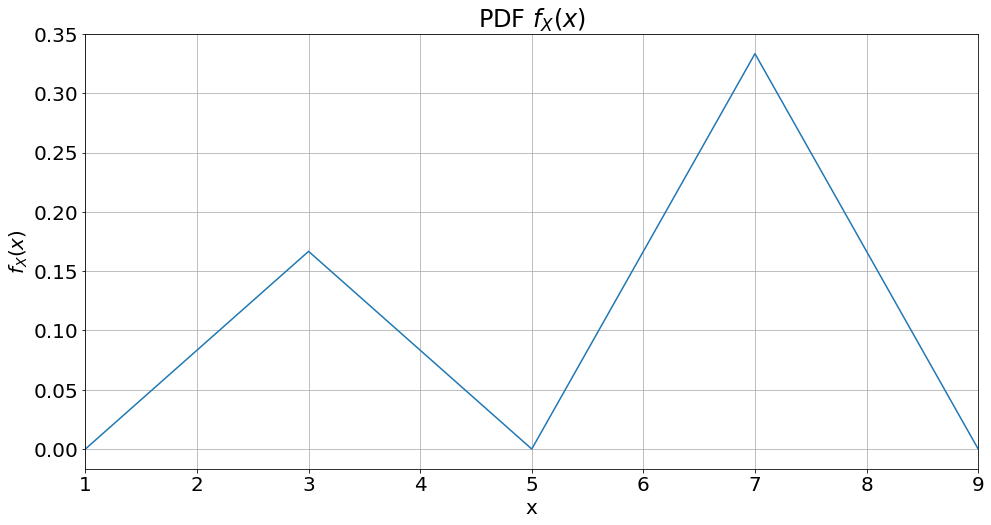

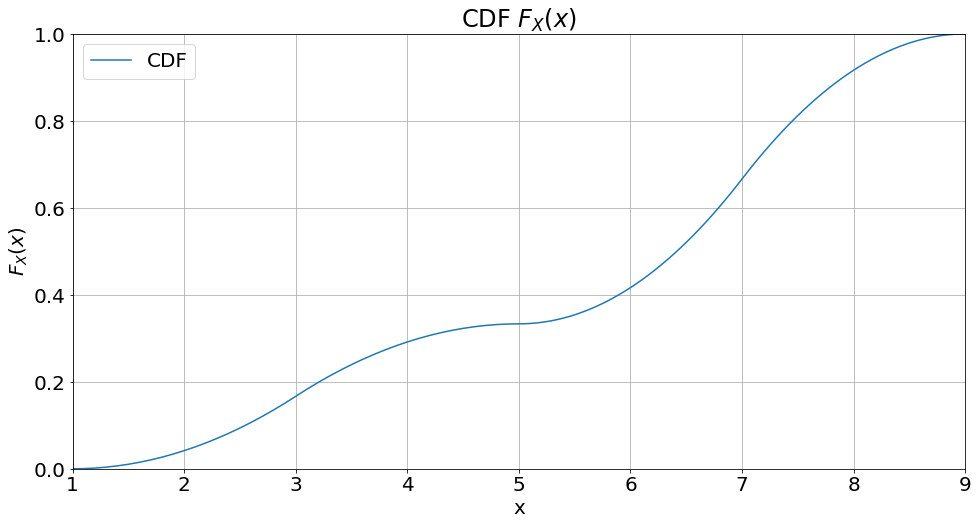

In [10]:
# 1. Visualize PDF and CDF

# Values for plots
plot_x = arange_inc(1, 9, 0.05)
plot_f = np.array([f_X(x) for x in plot_x])
plot_F = np.array([F_X(x) for x in plot_x])

# Plot the PDF f_X(x)
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('PDF $f_X(x)$')
ax.set_xlabel('x')
ax.set_ylabel('$f_X(x)$')
ax.set_xlim([1,9])
ax.plot(plot_x, plot_f, label='PDF')
ax.grid()
plt.show()

# Plot the CDF F_X(x)
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('CDF $F_X(x)$')
ax.set_xlabel('x')
ax.set_ylabel('$F_X(x)$')
ax.set_xlim([1,9])
ax.set_ylim([0,1])
ax.plot(plot_x, plot_F, label='CDF')
ax.legend()
ax.grid()
plt.show()

In [11]:
# 1.1 Take samples and compute expectation
def samples_x_inv_trans(F_X_inv, size):
    """
    Sample random variable X using Inverse Transform Sampling
    F_X_inv: inverse of the CDF
    size:    size of the array to generate
    """
    # Sample u uniformly on [0, 1]
    u = np.random.uniform(size=size)
    # Apply the inverse transform
    return F_X_inv(u)

# Generate 1,000,000 samples for x
sample_size: int = 10**6
x_samples_its = samples_x_inv_trans(F_X_inv, size=sample_size)
# Compute E_f[H] on these samples
exp_h_its: float = expectation_mc(h, x_samples_its)
# Report the results
print(f'Expectation of h(x) using Inverse Transform Sampling: {exp_h_its:0.6f}')

Expectation of h(x) using Inverse Transform Sampling: 0.058876


In [12]:
def samples_x_reject(f_X, size, a: float, b: float, y_max: float):
    """Sample random variable X using Rejection Sampling with a uniform proposal distribution
    f_X:   probability density function for f(x)
    size:  size of the array to generate
    a:     start of the support of f(x); left side of rectangular box
    b:     end of the support of f(x); right side of rectangular box
    y_max: maximum of f(x) on [a, b]; height of rectangular box
    """
    # Preallocate space for the drawn samples
    x_samples = np.zeros(size)
    # Count the number of samples drawn and attempts
    idx: int = 0
    attempts: int = 0
    # Continue drawing new samples until we've collected size of them
    while idx < size:
        # Draw a random value of x on [a, b]
        x = np.random.uniform(a, b)
        # Draw a random value of y on [0, y_max]; if y <= f_X(x), keep this sample
        if np.random.uniform(0, y_max) <= f_X(x):
            # Save the sample in slot idx, then increment idx
            x_samples[idx] = x
            idx += 1
        # Always increment attempts
        attempts += 1
    # Return the list of samples as well as the number of attempts
    return x_samples, attempts

# Generate samples with rejection sampling
# Maximum value of f(X) occurs at x=7
y_max: float = f_X(7)
x_samples_rs, attempts = samples_x_reject(f_X, sample_size, 1.0, 9.0, y_max)
# Report number of trials
print(f'Drew {sample_size} samples for x ~ f(x) in {attempts} attempts.')

# Compute E_f[H] on these samples
exp_h_rs: float = expectation_mc(h, x_samples_rs)
# Report the results
print(f'Expectation of h(x) using Rejection Sampling: {exp_h_rs:0.6f}')

Drew 1000000 samples for x ~ f(x) in 2661685 attempts.
Expectation of h(x) using Rejection Sampling: 0.058853


<div class="answer-separator">
------------------------
</div>

## Question 2: The Consequences of O-ring Failure can be Painful and Deadly

**Coding required**

In 1986, the space shuttle Challenger exploded during take off, killing the seven astronauts aboard. It is believed that the explosion was caused by the failure of an O-ring (a rubber ring that seals parts of the solid fuel rockets together), and that the failure was caused by the cold weather at the time of launch (31F).

In the file chall.txt, you will find temperature (in Fahrenheit) and failure data from 23 shuttle launches, where 1 stands for O-ring failure and 0 no failure. We assume that the observed temperatures are fixed and that, at temperature $t$, an O-ring fails with probability $f(\theta_{1}+\theta_{2}t)$ conditionally on $\Theta = (\theta_1, \theta_2)$.

$f(\v{z})$ is defined to be the logistic function -- $f(\v{ z }) = 1/(1 + \exp(\v{ -z }))$ 

**2.1.** Based on your own knowledge and experience, suggest a prior distribution for the regression parameters ($\theta_1, \theta_2$).  Make sure to explain your choice of prior. 

**2.2.** Produce 5000-10000 samples from the posterior distribution of $\Theta $ using rejection sampling, and plot them and their marginals. (This may take a while.)

**2.3.** Use the logit package in the `statsmodels` library to compute 68% confidence intervals on the $\theta$ parameters.  Compare those intervals with the 68% credible intervals from the posterior above. Overlay these on the above marginals plots. 

**2.4.** Use the MLE values from `statsmodels` and the posterior mean from **2.2** at each temperature to plot the probability of failure in the frequentist and bayesian settings as a function of temperature. What do you see? 

**2.5.** Compute the mean posterior probability for an O-ring failure at $t = 31^\circ F$. To do this you must calculate the posterior at $31^\circ F$ and take the mean of the samples obtained.

**2.6.** You can instead obtain the probability from the posterior predictive. Use the posterior samples to obtain samples from the posterior predictive at $31^\circ F$ and calculate the fraction of failures.

**2.7.** The day before a new launch, meteorologists predict that the temperature will be $T \sim N(68, 1)$ during take-off. Estimate the probability for an O-ring failure during this take-off. (You will calculate multiple predictives at different temperatures for this purpose).

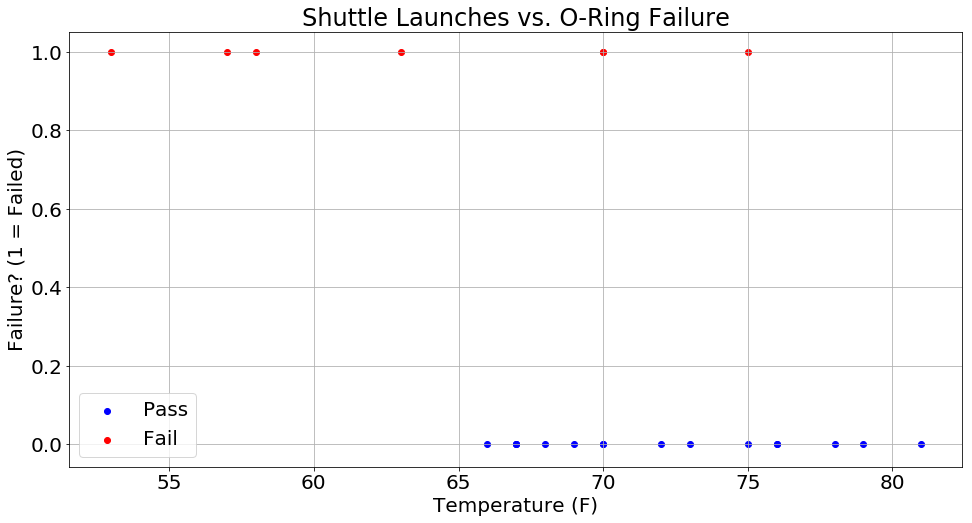

In [13]:
# 2. Visualize the data
# Download the file into a DataFrame
df = pd.read_csv('chall.txt', names=['temp', 'fail'], delim_whitespace=True, index_col=False)
# Alias into local variables
temp = df.temp.values
fail = df.fail.values
temp_pass = df[df.fail==0]['temp'].values
temp_fail = df[df.fail==1]['temp'].values

# Plot summary of data
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('Shuttle Launches vs. O-Ring Failure')
ax.set_xlabel('Temperature (F)')
ax.set_ylabel('Failure? (1 = Failed)')
ax.scatter(temp_pass, np.zeros_like(temp_pass), label='Pass', color='b')
ax.scatter(temp_fail, np.ones_like(temp_fail), label='Fail', color='r')
ax.legend(loc='lower left')
ax.grid()

**2.1** I rember the Challenger disaster vividly because I was nine years old when it happened and they played it endlessly on CNN.

I don't really know much about this phenomenon, so my inclination is to choose an uninformative prior.  A normal distribution seems like a good choice that is familiar and has high entropy.  I'm highly skeptical of making up parameter values for the prior without a good basis for them.  Instead, I went ahead and did the next part of this problem (please see below) and looked at the estimated parameter values for $\theta_1$ and $\theta_2$ as well as their standard errors.

The ML estimate of $\theta_1$ was 15.04, which I round to 15, and the standard error was 7.4.  I'll double that to about 15 so we have a broad range of candidate $\theta_1$ draws.  The ML estimate of $\theta_2$ was -0.23 with a standard error of 0.11.  Following a similar approach, I'll set a normal prior with mean -0.22 and standard deviation 0.22.

$$p(\theta_1) \sim N(15, 15)$$
$$p(\theta_2) \sim N(-0.22, 0.22)$$

In [15]:
def theta_prior_generic(theta_1_mean, theta_1_std, theta_2_mean, theta_2_std, size: int):
    """
    Draw samples for theta_1 and theta_2 on the prior distribution
    theta_2_mean:       the mean of theta_1 on a normal distribution
    theta_1_std:        the standard deviation of theta_1 on a normal distribution
    theta_2_mean:       the mean of theta_2 on a normal distribution
    theta_2_std:        the standard deviation of theta_2 on a normal distribution
    """
    # Preallocate storage; theta is an array of shape (size, 2)
    theta = np.zeros((size, 2))
    # Draw samples for theta_1 and theta_2
    theta[:, 0] = np.random.normal(loc=theta_1_mean, scale=theta_1_std, size=size)
    theta[:, 1] = np.random.normal(loc=theta_2_mean, scale=theta_2_std, size=size)
    # Return the combined theta array
    return theta

# Create an instance prior with bound parameter values
theta_1_mean = 15.0
theta_1_std = 15.0
theta_2_mean = -0.22
theta_2_std = 0.22
theta_prior = lambda size : theta_prior_generic(theta_1_mean, theta_1_std, theta_2_mean, theta_2_std, size)

<div class="answer-separator">
------------------------
</div>

## Question 3: Maximum Uniformity -- Frequentist Bootstraps and the Bayesian Posterior

**Coding required**

In 1986, the space shuttle Challenger exploded during take off, killing the seven astronauts aboard. It is believed that the explosion was caused by the failure of an O-ring (a rubber ring that seals parts of the solid fuel rockets together), and that the failure was caused by the cold weather at the time of launch (31F).

In the file chall.txt, you will find temperature (in Fahrenheit) and failure data from 23 shuttle launches, where 1 stands for O-ring failure and 0 no failure. We assume that the observed temperatures are fixed and that, at temperature $t$, an O-ring fails with probability $f(\theta_{1}+\theta_{2}t)$ conditionally on $\Theta = (\theta_1, \theta_2)$.

$f(\mathbf{z})$ is defined to be the logistic function -- $f(\mathbf{ z }) = 1/(1 + \exp(\mathbf{ -z }))$ 

**2.1.** Based on your own knowledge and experience, suggest a prior distribution for the regression parameters ($\theta_1, \theta_2$).  Make sure to explain your choice of prior. 

**2.2.** Produce 5000-10000 samples from the posterior distribution of $\Theta $ using rejection sampling, and plot them and their marginals. (This may take a while.)

**2.3.** Use the logit package in the `statsmodels` library to compute 68% confidence intervals on the $\theta$ parameters.  Compare those intervals with the 68% credible intervals from the posterior above. Overlay these on the above marginals plots. 

**2.4.** Use the MLE values from `statsmodels` and the posterior mean from **2.2** at each temperature to plot the probability of failure in the frequentist and bayesian settings as a function of temperature. What do you see? 

**2.5.** Compute the mean posterior probability for an O-ring failure at $t = 31^\circ F$. To do this you must calculate the posterior at $31^\circ F$ and take the mean of the samples obtained.

**2.6.** You can instead obtain the probability from the posterior predictive. Use the posterior samples to obtain samples from the posterior predictive at $31^\circ F$ and calculate the fraction of failures.

**2.7.** The day before a new launch, meteorologists predict that the temperature will be $T \sim N(68, 1)$ during take-off. Estimate the probability for an O-ring failure during this take-off. (You will calculate multiple predictives at different temperatures for this purpose).

<div class="answer-separator">
------------------------
</div>